✅ PART A — DATA PREPARATION


1️⃣ Load Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime


2️⃣ Load Data

In [65]:
sentiment = pd.read_csv("/content/fear_greed_index.csv")
trades = pd.read_csv("/content/historical_data.csv")

3️⃣ Basic Inspection

In [66]:
print("Sentiment shape:", sentiment.shape)
print("Trades shape:", trades.shape)

print(sentiment.isnull().sum())
print(trades.isnull().sum())

print("Duplicates in trades:", trades.duplicated().sum())


Sentiment shape: (2644, 4)
Trades shape: (211224, 16)
timestamp         0
value             0
classification    0
date              0
dtype: int64
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Duplicates in trades: 0


Document:

Rows

Columns

Missing values

Duplicates removed

In [67]:
trades = trades.drop_duplicates()


4️⃣ Convert Timestamp & Align Date

In [68]:
# Fix date parsing based on inspection: trades are string dates, sentiment are Unix timestamps
trades['Timestamp'] = pd.to_datetime(trades['Timestamp IST'], dayfirst=True)
trades['date'] = pd.to_datetime(trades['Timestamp'].dt.date)

sentiment['timestamp'] = pd.to_datetime(sentiment['timestamp'], unit='s')
sentiment['date'] = pd.to_datetime(sentiment['timestamp'].dt.date)

5️⃣ Merge Datasets

In [69]:
if 'date' in trades.columns and 'date' in sentiment.columns:
    merged = trades.merge(
        sentiment,
        on='date',
        how='left'
    )
    print("Merge successful. Merged shape:", merged.shape)
else:
    print("Error: 'date' column missing. Please ensure date conversion cell was run.")

Merge successful. Merged shape: (211224, 20)


Check missing merges:

In [70]:
merged['classification'].isnull().sum()

np.int64(6)

🔢 Create Key Metrics


1️⃣ Daily PnL per trader

In [71]:
daily_pnl = merged.groupby(['Account', 'date'])['Closed PnL'].sum().reset_index()

2️⃣ Win Rate per trader

In [72]:
merged['win'] = merged['Closed PnL'] > 0

win_rate = merged.groupby('Account')['win'].mean().reset_index()
win_rate.rename(columns={'win':'win_rate'}, inplace=True)

3️⃣ Leverage Distribution

In [73]:
# Calculate leverage: Position Size (USD) / Initial Margin (Start Position)
merged['leverage'] = merged['Size USD'] / merged['Start Position'].replace(0, np.nan)

# Calculate average leverage per trader
leverage_stats = merged.groupby('Account')['leverage'].mean().reset_index()
print(leverage_stats.head())

                                      Account       leverage
0  0x083384f897ee0f19899168e3b1bec365f52a9012     -56.528045
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  234004.140959
2  0x271b280974205ca63b716753467d5a371de622ab   -5470.651490
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4     895.519175
4  0x2c229d22b100a7beb69122eed721cee9b24011dd      21.747341


4️⃣ Trades per Day

In [74]:
trades_per_day = merged.groupby(['Account','date']).size().reset_index(name='trade_count')

5️⃣ Long / Short Ratio

In [75]:
print("Unique values in Side column:", merged['Side'].unique())
long_short = merged.groupby(['date','Side']).size().unstack().fillna(0)
# We will adjust the column names below based on the print output above
if 'LONG' in long_short.columns:
    long_short['long_short_ratio'] = long_short['LONG'] / (long_short.get('SHORT', 0) + 1)
else:
    print("Columns found after unstack:", long_short.columns.tolist())

Unique values in Side column: ['BUY' 'SELL']
Columns found after unstack: ['BUY', 'SELL']


✅ PART B — ANALYSIS

1️⃣ Performance: Fear vs Greed

Average Daily PnL

In [76]:
sentiment_pnl = merged.groupby('classification')['Closed PnL'].mean()
print(sentiment_pnl)

classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: Closed PnL, dtype: float64


Plot

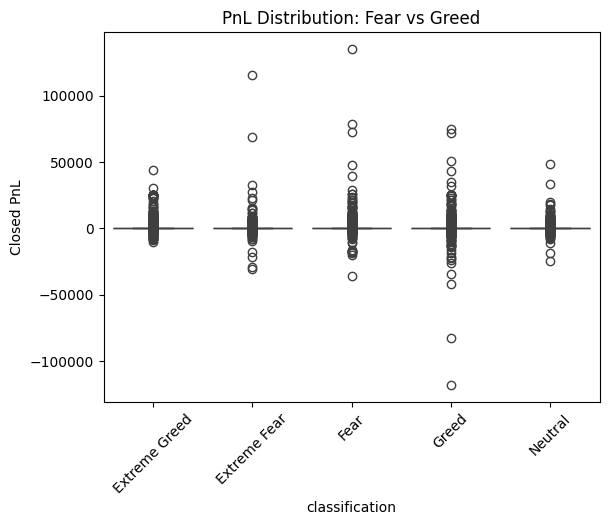

In [77]:
sns.boxplot(data=merged, x='classification', y='Closed PnL')
plt.title("PnL Distribution: Fear vs Greed")
plt.xticks(rotation=45)
plt.show()

In [78]:
print(merged.columns.tolist())
display(merged.head())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'date', 'timestamp', 'value', 'classification', 'win', 'leverage']


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,date,timestamp,value,classification,win,leverage
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,2024-12-02 22:50:00,2024-12-02,2024-12-02 05:30:00,80.0,Extreme Greed,False,NaN
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,2024-12-02 22:50:00,2024-12-02,2024-12-02 05:30:00,80.0,Extreme Greed,False,0.129424
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,2024-12-02 22:50:00,2024-12-02,2024-12-02 05:30:00,80.0,Extreme Greed,False,1.147739
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,2024-12-02 22:50:00,2024-12-02,2024-12-02 05:30:00,80.0,Extreme Greed,False,0.996059
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,2024-12-02 22:50:00,2024-12-02,2024-12-02 05:30:00,80.0,Extreme Greed,False,0.054091


2️⃣ Win Rate by Sentiment

In [79]:
merged['win'] = merged['Closed PnL'] > 0
win_by_sentiment = merged.groupby('classification')['win'].mean()
print(win_by_sentiment)

classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: win, dtype: float64


3️⃣ Leverage Behavior

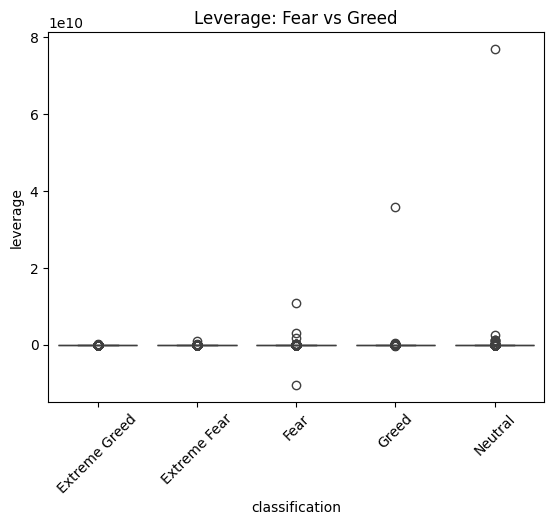

In [80]:
# Ensure leverage is calculated first
merged['leverage'] = merged['Size USD'] / merged['Start Position'].replace(0, np.nan)
sns.boxplot(data=merged, x='classification', y='leverage')
plt.title("Leverage: Fear vs Greed")
plt.xticks(rotation=45)
plt.show()

4️⃣ Trade Frequency

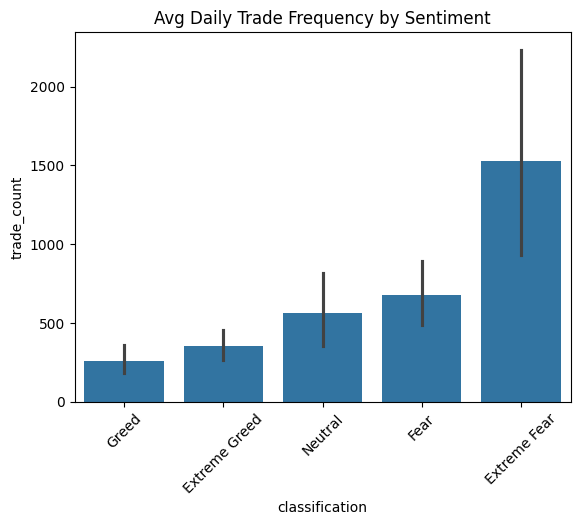

In [81]:
freq = merged.groupby(['date','classification']).size().reset_index(name='trade_count')
sns.barplot(data=freq, x='classification', y='trade_count', estimator=np.mean)
plt.title("Avg Daily Trade Frequency by Sentiment")
plt.xticks(rotation=45)
plt.show()

🔍 SEGMENT ANALYSIS

Segment 1 — High vs Low Leverage

In [82]:
merged['leverage_segment'] = np.where(
    merged['leverage'] > merged['leverage'].median(),
    "High Leverage",
    "Low Leverage"
)


Compare PnL:

In [83]:
merged.groupby(['leverage_segment','classification'])['Closed PnL'].mean()

leverage_segment  classification
High Leverage     Extreme Fear       29.798856
                  Extreme Greed     129.746381
                  Fear               42.842604
                  Greed              66.444278
                  Neutral            36.569835
Low Leverage      Extreme Fear       40.289673
                  Extreme Greed      15.098348
                  Fear               66.283689
                  Greed              24.338778
                  Neutral            31.805129
Name: Closed PnL, dtype: float64

Segment 2 — Frequent vs Infrequent Traders

In [84]:
account_freq = merged.groupby('Account').size().reset_index(name='total_trades')

threshold = account_freq['total_trades'].median()

account_freq['segment'] = np.where(
    account_freq['total_trades'] > threshold,
    "Frequent",
    "Infrequent"
)

merged = merged.merge(account_freq[['Account','segment']], on='Account')

Analyze:

In [85]:
merged.groupby(['segment','classification'])['Closed PnL'].mean()

segment     classification
Frequent    Extreme Fear       34.163353
            Extreme Greed      62.870911
            Fear               51.323784
            Greed              25.004641
            Neutral            34.579701
Infrequent  Extreme Fear       35.941979
            Extreme Greed     103.264685
            Fear               80.835791
            Greed             210.210287
            Neutral            31.845656
Name: Closed PnL, dtype: float64

Segment 3 — Consistent Winners

In [86]:
account_pnl = merged.groupby('Account')['Closed PnL'].sum().reset_index()

account_pnl['performance_segment'] = np.where(
    account_pnl['Closed PnL'] > 0,
    "Consistent Winner",
    "Inconsistent"
)

merged = merged.merge(account_pnl[['Account','performance_segment']], on='Account')